<a href="https://colab.research.google.com/github/tudorcap/cap-comp215/blob/main/COMP_215_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - Project 2 (Traffic Flow Simulation)
-----------------------------------------------
#### Name: Tudor Bita
#### Date: Apr 21 2024

This project is a continuation of the elementary [Cellular Automata](https://en.wikipedia.org/wiki/Elementary_cellular_automaton) studied by [Stephen Wolfram](https://en.wikipedia.org/wiki/Stephen_Wolfram#Complex_systems_and_cellular_automata) covered in Lab 5.

**New Python concepts**:
  * **[NumPy](https://numpy.org)** is an open-source scientific computing package.
  * 1D and 2D [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html) -  a rectangular grid with efficient matrix operations.

**New Computation concepts**:
  * **bit sequence** (a.k.a. binary number) - using a sequence of 0's and 1's to efficiently represent a data structure and processes.

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In Lab 5 we extended and experimented with a simple Cellular Automata class named Cell1D to re-produce
some of Wolfram’s original experiments. Wolfram Rule 184 produces patterns that exhibit some features of
stop-and-go traffic https://en.wikipedia.org/wiki/Rule_184#Traffic_flow
This interpretation can be hard to visualize when the pattern is presented as a 2D grid, but becomes apparent
when viewed as a 1D animation, using each CA state vector as a “frame” in the animation.
In this project, we will explore Rule 184 as an animation and extend the model to produce a more realistic
simulation of stop-and-go traffic. Finally, we run an experiment to determine the critical threshold at which we
might expect stop-and-go traffic to form.

As usual, the first code cell simply imports all the modules we'll be using...

In [131]:
%matplotlib inline

import time
from typing import Protocol

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')


This next code is copied from Lab 5 and adjusted to meet the requirements of the project. The rule_indexes() has been adjusted to "wrap" the "cars" from one edge to the other edge. The start_random(n_cells, p) function was designed to have the "cars" be randomly placed along the "highway" of length n_cells.

In [132]:
POWERS_OF_2 = np.array((4, 2, 1))

def rule_indexes(state):
    """ Return vector of rule indexes - one index for each 3-cell neighborhood in the CA state vector. """
    # Pad ends of state array with extra cells to create the "wrapped" effect
    padded_state = np.concatenate((state[-1:], state, state[:1]))
    return np.correlate(padded_state, POWERS_OF_2, mode='valid')


def transition(state, rule):
    """ Return the vector resulting from a transition of given CA state under the given 8-bit rule """
    indexes = rule_indexes(state)
    return np.array(rule[indexes])  # "vector indexing" replaces: [rule[i] for i in indexes]

rule_110 = (0,1,1,0,1,1,1,0)[::-1]
assert all( transition(np.array((0,0,1,1,1,0,0,0,1,1,0)), np.array(rule_110)) == (0,1,1,0,1,0,0,1,1,1,0))


# This algorithm is from the textbook - it uses numpy to do a decimal to binary conversion.
def get_lookup_table(rule):
    """
    Return the 8-bit transition vector for the given elementary CA rule number.
    rule: int 0-255
    returns: transition lookup table - a 8 element vector of 0s and 1s
    """
    rule = np.array([rule], dtype=np.uint8)
    return np.unpackbits(rule)[::-1]

assert np.all( get_lookup_table(110) == rule_110 )

def start_random(n_cells, p=0.5):
    state = np.random.choice([0, 1], size=n_cells, p=[1 - p, p])
    return state

def simulate_ca(n_cells, n_steps, rule):
    """ Generate a CA with given number of cells, plot progression of rule for given number of time steps """
    start_state = start_random(n_cells)
    # create a stack of "empty" state vectors, one for each time step
    ca_timesteps = np.vstack([start_state, np.zeros((n_steps, len(start_state)), dtype=np.uint8)])
    # run the simulation
    for t in range(1, n_steps):
        ca_timesteps[t] = transition(ca_timesteps[t-1], rule)
    return ca_timesteps


def plot_ca(array, axes=None, title='', cmap='Blues', **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set(
        title=title

    )
    # Turn off axes labels and tick marks
    axes.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axes.tick_params(axis='y', which='both', left=False, labelleft=False)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)




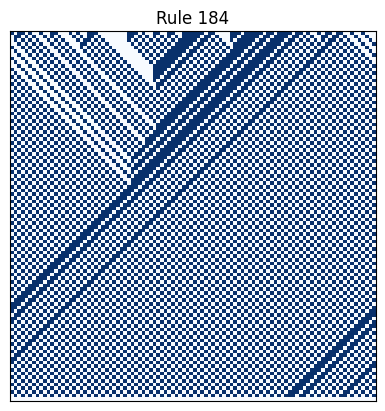

In [133]:
rule_184 = get_lookup_table(184)
ca_timesteps = simulate_ca(100, 100, rule_184)
plot_ca(ca_timesteps, title=f'Rule 184')

The plotted data shows how Rule 184 works. Each "car" can only move to the right if there is no "car" infront it.

A Class of Cell1D is desgined to be able to simulate the movement of the "cars" over a course of n_step.

In [134]:
class Cell1D:
  def __init__(self,state,rule):
    self.state = state
    self.rule_number = rule
    self.rule = get_lookup_table(rule)

  def simulate(self, n_step=10):
      """Generate this CA for a given number of time steps."""
      for _ in range(n_step):
          self.step()  # Apply the transition rule to evolve the CA by one step
      return self.state  # Return the final state after simulation

  def step(self):
    self.state = transition(self.state, self.rule)

  def draw(self, axes, step):
    state_reshaped = self.state.reshape(1, self.state.size)
    plot_ca(state_reshaped, title=f"Graph plot for rule {self.rule_number}")


A simple example can be made to show how the plot of Rule 184 looks after the simulations. The problem with this is it only shows the end image. This example doesn't show how the image starts and its progress.

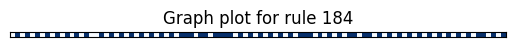

In [135]:
ca = Cell1D(start_random(100), 184)
ca.simulate(10)

ca.draw((10,10),10)

In order to visualize the progression of the "cars", a Animation2D class must be used to animate the images to show how the "cars" are moving. This Animation2D class is taken from cap-comp215 repo, in the lessons/06-animation-2D notebook.

In [136]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model:Cell1D, frames=25, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass




This Animation2D class allows the traffic flow to be visualized. This example below shows a Cell1D cellular automata with a 50 cell long "highway" of 1s and 0s each having a 50% chance to be present along the "highway" using the rule 184. The animation shows how the CA starts and how the "cars" move along the "highway".

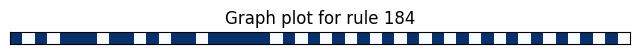

In [137]:
ca = Cell1D(start_random(50,0.5), 184)
animation = Animation2D(ca)
animation.animate()

Using ChatGPT, this run_experiments(density_values, num_simulations) function was designed to run simulations of the CA at different values of p and compare that to the amount of resulting traffic jams at different values of p.

 The function creates a Cell1D object with random start state based on density p. The function then simulates 50 steps for each simulation. Whilst that is happening, the function is counting the amount of traffic jams by counting clusters of 1's as traffic jams. The function takes the average number of traffic jams by dividing the total_jams by the num_simulations.The function returns the amount of traffic jams for each value of p in a list.

  The function is then plotted to show the relation between 2 values.

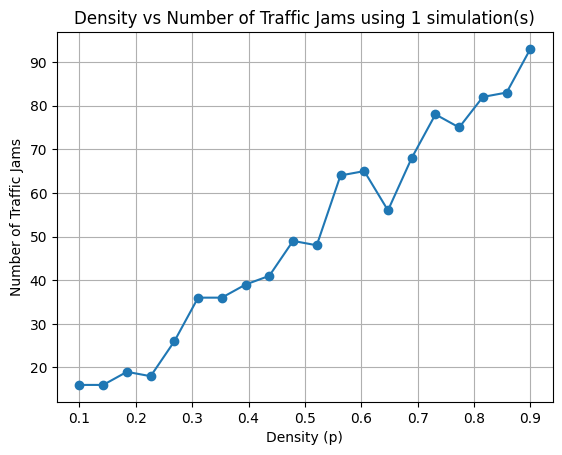

In [138]:
# Used ChatGPT to design this experiment function that includes a process of counting traffic jams

# Define a function to run experiments for different densities(p) and count traffic jams
def run_experiments(density_values, num_simulations):
    traffic_jams = []
    for p in density_values:
        total_jams = 0
        for _ in range(num_simulations):
            # Create Cell1D object with random start state based on density
            ca = Cell1D(start_random(100,p), 184)
            # Run simulation for a few steps
            for _ in range(50):
                ca.step()
            # Count number of traffic jams (custom logic based on CA state)
            # For example, count clusters of 1's as traffic jams
            jams = np.sum(ca.state[:-1] == 1)
            total_jams += jams
        average_jams = total_jams / num_simulations
        traffic_jams.append(average_jams)
    return traffic_jams

# Define density values (p) and number of simulations per density
density_values = np.linspace(0.1, 0.9, 20)  # Example range of densities
num_simulations = 1  # Number of simulations per density

# Run experiments and collect data
traffic_jams_data = run_experiments(density_values, num_simulations)

# Plotting the relation between density and number of traffic jams
plt.plot(density_values, traffic_jams_data, marker='o')
plt.xlabel('Density (p)')
plt.ylabel('Number of Traffic Jams')
plt.title(f'Density vs Number of Traffic Jams using {num_simulations} simulation(s)')
plt.grid(True)
plt.show()


When using only 1 simulation for every value of p, the plot is very random. It does follow a continuosly growing pattern but each point is random compared to its neighbours.

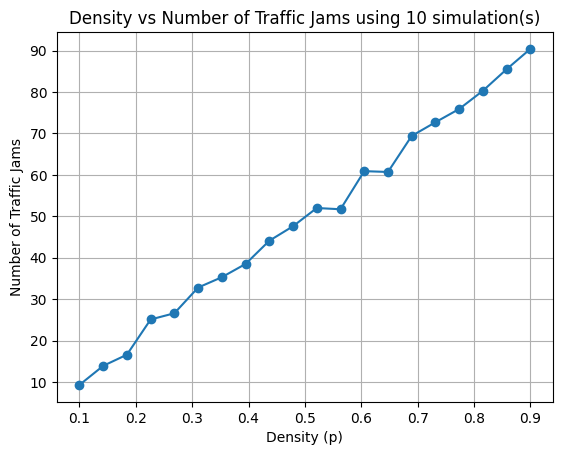

In [139]:
# Define density values (p) and number of simulations per density
density_values = np.linspace(0.1, 0.9, 20)  # Example range of densities
num_simulations = 10  # Number of simulations per density

# Run experiments and collect data
traffic_jams_data = run_experiments(density_values, num_simulations)

# Plotting the relation between density and number of traffic jams
plt.plot(density_values, traffic_jams_data, marker='o')
plt.xlabel('Density (p)')
plt.ylabel('Number of Traffic Jams')
plt.title(f'Density vs Number of Traffic Jams using {num_simulations} simulation(s)')
plt.grid(True)
plt.show()

When using only 10 simulations for every value of p, the plot is less random and more linear. A more apparent pattern forms of linear growth.

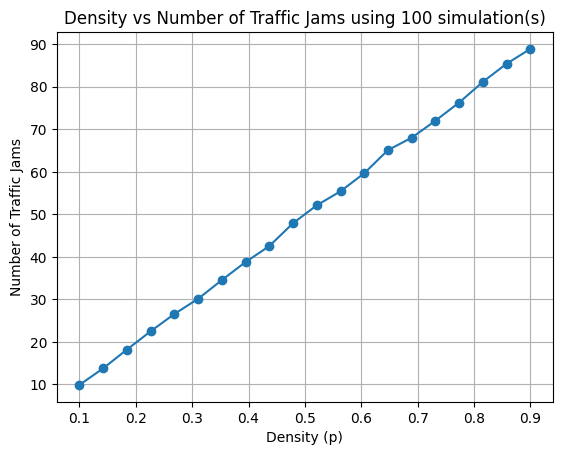

In [140]:
# Define density values (p) and number of simulations per density
density_values = np.linspace(0.1, 0.9, 20)  # Example range of densities
num_simulations = 100  # Number of simulations per density

# Run experiments and collect data
traffic_jams_data = run_experiments(density_values, num_simulations)

# Plotting the relation between density and number of traffic jams
plt.plot(density_values, traffic_jams_data, marker='o')
plt.xlabel('Density (p)')
plt.ylabel('Number of Traffic Jams')
plt.title(f'Density vs Number of Traffic Jams using {num_simulations} simulation(s)')
plt.grid(True)
plt.show()

When using 100 simulations for every value of p, the plot is very linear. A much more apparent pattern forms of linear growth.


# **Extending Rule 184**
The ‘traffic rules’ encode in Rule 184 mean a “car” starts to move as soon as the car in front moves. But in
reality, there is a delay that contributes to congestion. The CA is extended to use a 4 bit rule that “looks ahead” 2
cells and only moves if there are 2 empty cells in front.

A complete set of state transitions for this new rule for all 16 possible 4-bit states from 1111
to 0000 are mapped out. The new state value falls under the 2nd bit (1 “arriving” bit, and 2 “lookahead” bits). This was mapped out by ChatGPT.

The rule should yield a 16 bit binary “rule”. The rule is converted to it’s decimal rule number by using the binary_to_decimal(binary_array) function. This function was designed by ChatGPT.

The correlation window is adjusted to match the extension of Rule 184. The matching correlation window is: [8, 4, 2, 1]  And both edges are padded with 2 values that are gathered by "wrapping" the edge of the object.



In [158]:
POWERS_OF_2_4BIT = np.array((8, 4, 2, 1))  # Updated for 4-bit rule

def rule_indexes_4bit(state):
    """ Return vector of rule indexes for a 4-bit neighborhood """
    padded_state = np.concatenate((state[-2:], state, state[:2]))
    return np.correlate(padded_state, POWERS_OF_2_4BIT, mode='valid')

def transition_4bit(state, rule):
    """ Return the vector resulting from a transition of given CA state under the given 4-bit rule """
    indexes = rule_indexes_4bit(state)
    return np.array(rule[indexes])

def get_lookup_table_4bit(rule):
    """
    Return the transition lookup table for the given 4-bit neighborhood rule number.

    returns: transition lookup table - a 16 element vector of 0s and 1s
    """
    # Convert rule number to binary and reverse it
    rule_binary = np.unpackbits(np.array([rule], dtype=np.uint8))[::-1]
    # Trim leading zeros and return the lookup table
    return rule_binary

transitions = {
    "1111": 0, "1110": 0, "1101": 0, "1100": 1,
    "1011": 0, "1010": 0, "1001": 0, "1000": 0,
    "0111": 0, "0110": 0, "0101": 0, "0100": 0,
    "0011": 0, "0010": 1, "0001": 0, "0000": 0
}
def binary_to_decimal(binary_array):
    decimal = 0
    power = len(binary_array) - 1
    for digit in binary_array:
        if digit == 1:
            decimal += 2 ** power
        power -= 1
    return decimal

def get_rule_number(transitions):
    binary_array = []
    for key in sorted(transitions.keys(), reverse=True):
        binary_array.append(transitions[key])
    return binary_array



rule_184_4bit = get_rule_number(transitions)
decimal_rule_184 = binary_to_decimal(rule_184_4bit)
assert binary_to_decimal([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]) == 46535


class Cell1D_4bit:
    def __init__(self, state, rule):
        self.state = state
        self.rule = get_lookup_table_4bit(rule)
        self.rule_number = rule


    def step(self):
        self.state = transition_4bit(self.state, self.rule)

    def draw(self, axes, step):
        state_reshaped = self.state.reshape(1, self.state.size)
        plot_ca(state_reshaped, title=f"Graph plot for rule {self.rule_number}")



IndexError: index 13 is out of bounds for axis 0 with size 8

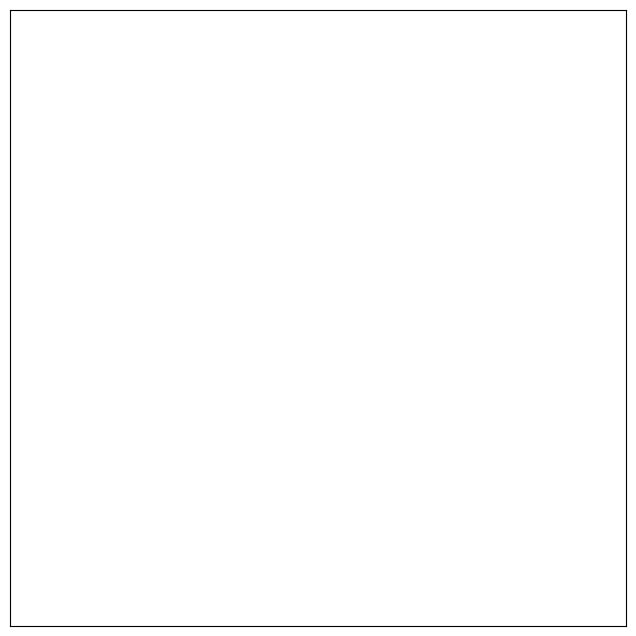

In [159]:
ca = Cell1D_4bit(start_random(100,0.5), decimal_rule_184)
animation = Animation2D(ca)
animation.animate()

Repeat the experiment to find the critical value of p where stop-and-go traffic begins. At lower values of p, you
should see a stable pattern emerge that allows a smooth flow of traffic. How would translate this pattern back
into a driving rule that would avoid stop-and-go traffic if all drivers followed it?

In [ ]:
# Define the 4-bit rule for traffic simulation
# Example rule where a car moves only if there are 2 empty cells in front
# 1111 1110 1101 1011 0111 1111 1111 1111
rule_4bit = [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]

# Create Cell1D_4bit object for the extended rule
ca_4bit = Cell1D_4bit(start_random(100), rule_4bit)

# Run the simulation for a few steps
for _ in range(50):
    ca_4bit.step()

# Plot the extended traffic simulation
plt.figure(figsize=(8, 6))
plt.imshow(ca_4bit.draw(), cmap='Blues', aspect='auto')
plt.title('Extended Rule 184 Traffic Simulation')
plt.xlabel('Cells')
plt.ylabel('Time Steps')
plt.colorbar()
plt.show()


# Algorithm Analysis

Perform an analysis of the algorithms used to generate n generations for a CA that is m cells wide.
1. What is the Big-O time complexity of the algorithm we are using here? What implications does that
have for running larger or longer CA experiments?
2. Use Python’s timeit to do some actual timings to support your algorithm analysis.

In [167]:


import timeit
from functools import partial

# Sample CA simulation function
def simulate_CA(m, n):

    ca = Cell1D(start_random(m), 184)
    for _ in range(n):
        ca.step()


# Define parameters for the simulation
m_cells = 1000  # Number of cells in the CA
generations = 1000  # Number of generations to simulate

# Define a partial function for timeit
partial_simulate_CA = partial(simulate_CA, m_cells, generations)

# Measure the time taken for simulation
execution_time = timeit.timeit(partial_simulate_CA, number=1)

print(f"Execution time for {generations} generations in a {m_cells}-cell CA: {execution_time:.4f} seconds")


Execution time for 1000 generations in a 1000-cell CA: 0.0501 seconds


Based off appearance, the Big-O time complexity of this algorithim is O(n*m).

Based off the timeit timings, that theory is not supported. The m cells barely affects the time it takes to simulate CA. Where as n generations greatly affect the time it takes to simulate CA. The true Big-O time complexity of this algorithm is O(n).